# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo2_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



We first load the standard packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `pytorch`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification.

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
If you are using Google colab, the packages are already installed.
After you have installed the package, try to import it.

In [2]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [ ]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
response = requests.get(url)
with open(fn, "wb") as f:
    f.write(response.content)

Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [6]:
# TODO
# y, sr = ...
y, sr = librosa.load(fn, sr=None)
print(len(y))

708859


Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

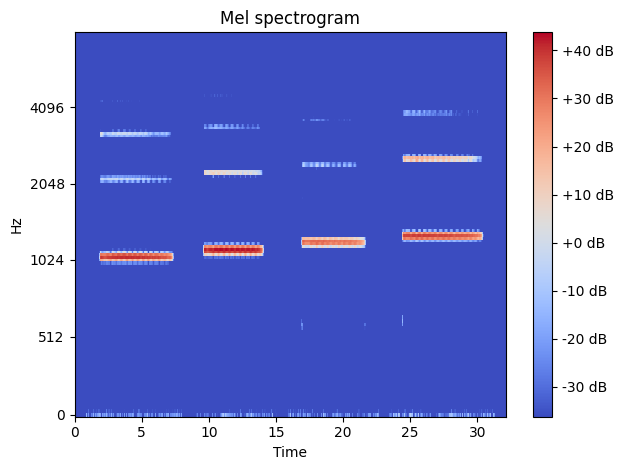

In [8]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()


## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, they then segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [11]:
data_dir = 'instrument_dataset/'
import os
fn = os.path.join(data_dir, 'uiowa_train_data.npy')
Xtr = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_train_labels.npy')
ytr = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_test_data.npy')
Xts = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_test_labels.npy')
yts = np.load(fn)

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class?


In [12]:
# TODO
#  ntr = ...
#  nts = ...
#  nfeatures = ...
#  nclasses = ...

ntr = Xtr.shape[0]
nts = Xts.shape[0]
nfeatures = Xtr.shape[1]
nclasses = len(np.unique(ytr))

print(f"Number of training samples: {ntr}")
print(f"Number of test samples: {nts}")
print(f"Number of features per sample: {nfeatures}")
print(f"Number of instrument classes: {nclasses}")

Number of training samples: 66247
Number of test samples: 14904
Number of features per sample: 120
Number of instrument classes: 10


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [13]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
# Xts_scale = ...
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr_scale = scaler.fit_transform(Xtr)
Xts_scale = scaler.transform(Xts)


## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb).   create a neural network `model` with:
* `nfeatures` inputs
* `nh=256` hidden units
* `sigmoid` activation
* fully connected layer with `nclasses` outputs
* `nn.Softmax` output
* select the input and output shapes correctly


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create the neural network
#    class Model(nn.Module):
#       def __init__(...):
#           ...
#       def forward(...):
#           ...

class Model(nn.Module):
    def __init__(self, n_in, n_hid, n_out):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# TODO:  Create the model
#  nhid = 256
#  model = Model(...)
nh = 256
model = Model(nfeatures, nh, nclasses)

Now print a summary of the model.  You can use the `torchsummary.summary` method as follows:

In [16]:
from torchsummary import summary

# TODO
#   summary(model, ...)  # put in the input shape
summary(model, (nfeatures,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          30,976
            Linear-2                   [-1, 10]           2,570
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


Next, create `pytorch` `Dataloader` classes from the numpy arrays.  Note that you must use the scaled data `Xtr_scale` and `Xts_scale`.

In [17]:
from torch.utils.data import DataLoader, TensorDataset

# TODO:  Convert your data to PyTorch tensors.
# Xtr_torch = ...  (use dtype=torch.float32)
# Xts_torch = ...  (use dtype=torch.float32)
# ytr_torch = ...  (use dtype=torch.int32)
# yts_torch = ...  (use dtype=torch.int32)

Xtr_torch = torch.tensor(Xtr_scale, dtype=torch.float32)
Xts_torch = torch.tensor(Xts_scale, dtype=torch.float32)
ytr_torch = torch.tensor(ytr, dtype=torch.int64)
yts_torch = torch.tensor(yts, dtype=torch.int64)


# TODO:  Create a TensorDataset
#   train_dataset = TensorDataset(...)
#   test_dataset = TensorDataset(...)

train_dataset = TensorDataset(Xtr_torch, ytr_torch)
test_dataset = TensorDataset(Xts_torch, yts_torch)

# TODO:  Create a DataLoader
#    train_loader = ...
#    test_loader = ...
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Create the loss and an optimizer.  For the loss, use `nn.CrossEntropyLoss()`.  For the optimizer, use the `optim.Adam` optimizer with a learning rate of 0.001

In [18]:
import torch.optim as optim

# TODO: Define loss function and optimizer
#   criterion = ...
#   optimizer = ...
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Fit the model for 20 epochs using the scaled data for both the training and validation.  In each epoch, save the:
*  average training loss
*  training accuracy
*  test accuracy

Your final test accuracy should be >95%.

In [19]:
# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 20

# Training loop
for epoch in range(epochs):

  # TODO:  Train over epoch
  #   model.train()
  #   for (data,target) in train_loader:
  #       ...
  #   loss_history.append(...)
  #   train_accuracy_history.append(...)
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
    avg_loss = total_loss / total
    train_acc = correct / total
    loss_history.append(avg_loss)
    train_accuracy_history.append(train_acc)

    # TODO:  Test over epoch
    #   model.eval()
    #   for (data,target) in test_loader:
    #       ...
    #   test_accuracy_history.append(...)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    test_acc = correct / total
    test_accuracy_history.append(test_acc)

    # TODO:  Print accuracy
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/20, Loss: 1.7546, Train Acc: 0.7249, Test Acc: 0.8062
Epoch 2/20, Loss: 1.6443, Train Acc: 0.8212, Test Acc: 0.8225
Epoch 3/20, Loss: 1.6083, Train Acc: 0.8560, Test Acc: 0.8625
Epoch 4/20, Loss: 1.6031, Train Acc: 0.8590, Test Acc: 0.8602
Epoch 5/20, Loss: 1.6008, Train Acc: 0.8606, Test Acc: 0.8633
Epoch 6/20, Loss: 1.5994, Train Acc: 0.8614, Test Acc: 0.8639
Epoch 7/20, Loss: 1.5608, Train Acc: 0.9025, Test Acc: 0.9243
Epoch 8/20, Loss: 1.5372, Train Acc: 0.9251, Test Acc: 0.9256
Epoch 9/20, Loss: 1.5356, Train Acc: 0.9258, Test Acc: 0.9263
Epoch 10/20, Loss: 1.5350, Train Acc: 0.9260, Test Acc: 0.9263
Epoch 11/20, Loss: 1.5342, Train Acc: 0.9264, Test Acc: 0.9261
Epoch 12/20, Loss: 1.5336, Train Acc: 0.9267, Test Acc: 0.9172
Epoch 13/20, Loss: 1.5332, Train Acc: 0.9268, Test Acc: 0.9251
Epoch 14/20, Loss: 1.5329, Train Acc: 0.9271, Test Acc: 0.9253
Epoch 15/20, Loss: 1.5325, Train Acc: 0.9272, Test Acc: 0.9257
Epoch 16/20, Loss: 1.5045, Train Acc: 0.9585, Test Acc: 0.9612
E

Plot the validation accuracy saved in `test_accuracy_history`.  

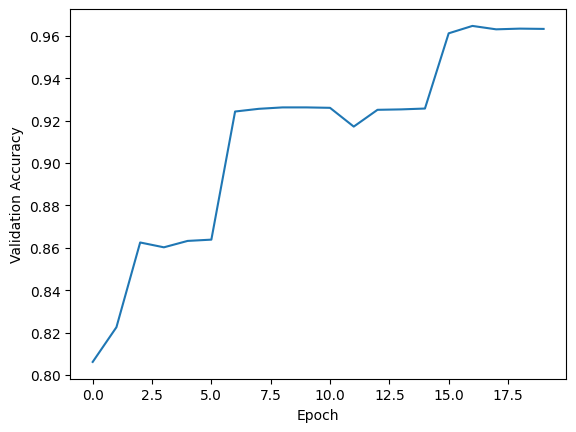

In [22]:
# TODO
plt.plot(test_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

Plot the loss values saved in the `loss_history`.  You should see that the loss is steadily decreasing.  Use the `semilogy` plot.

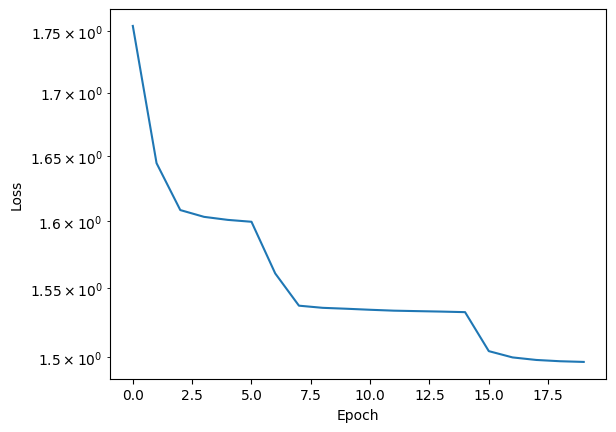

In [23]:
# TODO
plt.semilogy(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying four learning rates as shown in the vector `rates`.  For each learning rate:
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model for 20 epochs
* Save the accuracy and losses

In [25]:
rates = [1e-4, 1e-3, 1e-2]
test_acc_lr = []
loss_hist_lr = []

# TODO
for lr in rates:

    # TODO:  Create the model
    # model = Model(...)
    model = Model(nfeatures, nh, nclasses)


    # TODO: Define loss function and optimizer
    #   criterion = ...
    #   optimizer = ...
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)


    # Lists to store training and testing accuracy for each epoch
    train_accuracy_history = []
    test_accuracy_history = []
    loss_history = []

    # Number of epochs
    epochs = 20

    # Training loop
    for epoch in range(epochs):

      # TODO:  Train over epoch
      #   model.train()
      #   for (data,target) in train_loader:
      #       ...
      #   loss_history.append(...)
      #   train_accuracy_history.append(...)
      model.train()
      total_loss = 0
      correct = 0
      total = 0
      for data, target in train_loader:
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item() * data.size(0)
          pred = output.argmax(dim=1)
          correct += (pred == target).sum().item()
          total += target.size(0)
      avg_loss = total_loss / total
      train_acc = correct / total
      loss_history.append(avg_loss)
      train_accuracy_history.append(train_acc)

      # TODO:  Test over epoch
      #   model.eval()
      #   for (data,target) in test_loader:
      #       ...
      #   test_accuracy_history.append(...)
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for data, target in test_loader:
              output = model(data)
              pred = output.argmax(dim=1)
              correct += (pred == target).sum().item()
              total += target.size(0)
      test_acc = correct / total
      test_accuracy_history.append(test_acc)


      # TODO:  Print accuracy
      print(f"LR={lr}, Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f},\
        Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

      # TODO:  Save the loss history
      #   loss_hist_lr.append(...)
      #   test_acc_hist_lr.append(...)
    loss_hist_lr.append(loss_history)
    test_acc_lr.append(test_accuracy_history)

LR=0.0001, Epoch 1/20, Loss: 1.9829, Train Acc: 0.5676, Test Acc: 0.5170
LR=0.0001, Epoch 2/20, Loss: 1.8379, Train Acc: 0.6424, Test Acc: 0.6247
LR=0.0001, Epoch 3/20, Loss: 1.7608, Train Acc: 0.7312, Test Acc: 0.6908
LR=0.0001, Epoch 4/20, Loss: 1.7112, Train Acc: 0.7738, Test Acc: 0.7587
LR=0.0001, Epoch 5/20, Loss: 1.6799, Train Acc: 0.8005, Test Acc: 0.7729
LR=0.0001, Epoch 6/20, Loss: 1.6672, Train Acc: 0.8078, Test Acc: 0.7916
LR=0.0001, Epoch 7/20, Loss: 1.6595, Train Acc: 0.8122, Test Acc: 0.7947
LR=0.0001, Epoch 8/20, Loss: 1.6385, Train Acc: 0.8354, Test Acc: 0.8397
LR=0.0001, Epoch 9/20, Loss: 1.6233, Train Acc: 0.8474, Test Acc: 0.8405
LR=0.0001, Epoch 10/20, Loss: 1.6190, Train Acc: 0.8497, Test Acc: 0.8499
LR=0.0001, Epoch 11/20, Loss: 1.6161, Train Acc: 0.8514, Test Acc: 0.8490
LR=0.0001, Epoch 12/20, Loss: 1.6138, Train Acc: 0.8527, Test Acc: 0.8533
LR=0.0001, Epoch 13/20, Loss: 1.6120, Train Acc: 0.8539, Test Acc: 0.8559
LR=0.0001, Epoch 14/20, Loss: 1.6105, Train Acc

Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower.  The higher learning rate either plateaus at a lower validation accuracy or is unstable.

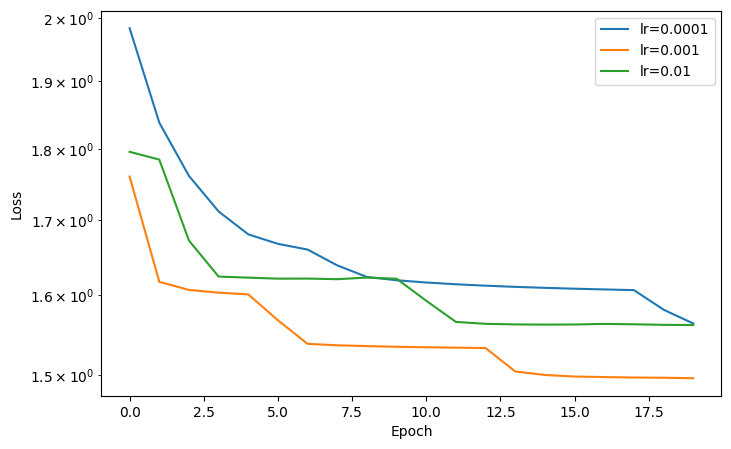

In [26]:
# TODO
plt.figure(figsize=(8,5))
for i, lr in enumerate(rates):
    plt.semilogy(loss_hist_lr[i], label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
